In [13]:
%pip install numpy matplotlib scapy[basic] tqdm tabulate

  Using cached https://files.pythonhosted.org/packages/62/20/4d43e141b5bc426ba38274933ef8e76e85c7adea2c321ecf9ebf7421cedf/numpy-1.18.1-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/7e/07/4b361d6d0f4e08942575f83a11d33f36897e1aae4279046606dd1808778a/matplotlib-3.1.3-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/cd/80/5bb262050dd2f30f8819626b7c92339708fe2ed7bd5554c8193b4487b367/tqdm-4.42.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/5d/bc/1e58593167fade7b544bfe9502a26dc860940a79ab306e651e7f13be68c2/pyparsing-2.4.6-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/f8/a1/5742b56282449b1c0968197f63eae486eca2c35dcd334bab75ad524e0de1/kiwisolver-1.1.0-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/f7/d2/e07d3ebb2bd7af696440ce7e754c59dd546ffe1bbe732c8ab68b9c834e61/cycler-0.10.0-py2.py3-none-any.whl
  Using cached ht

In [2]:
import random
import numpy as np
from tqdm import tqdm
from scapy.all import PcapReader
from scapy.layers.dot11 import Dot11ProbeReq


def accumulate(file, *accumulators):
    with PcapReader(file) as reader, tqdm(unit='packets', desc=file) as pbar:
        for packet in reader:
            for accumulator in accumulators:
                accumulator(packet)
            pbar.update()
        return accumulators


class TimeSeriesAccumulator(list):
    TYPE = ('timestamp', np.float), ('mac', np.bytes_, 6)
    
    def __call__(self, packet):
        if packet.haslayer(Dot11ProbeReq):
            timestamp = packet.time
            mac = bytes.fromhex(packet.addr2.replace(':', ''))
            self.append((timestamp, mac))
            
    def as_numpy_array(self):
        return np.array(self, dtype=np.dtype([*self.TYPE]))


class RandomProbeSampler(list):
    PROBABILITY = 0.001
    
    def __call__(self, packet):
        if packet.haslayer(Dot11ProbeReq) and random.random() <= self.PROBABILITY:
            self.append(packet)

In [3]:
from captures import commutes, make_legend

commute_time_series = dict()  # commute -> feature matrix
commute_samples = dict()  # commute -> list of probe request samples

for commute in commutes:
    features, samples = accumulate(commute.filename, TimeSeriesAccumulator(), RandomProbeSampler())
    commute_time_series[commute] = features.as_numpy_array()
    commute_samples[commute] = samples

capture-0-a4.pcap: 57279packets [01:05, 869.98packets/s] 
capture-1-a4.pcap: 67268packets [01:19, 847.53packets/s] 
capture-2-a4.pcap: 59223packets [01:10, 834.66packets/s] 
capture-5-a4.pcap: 67624packets [01:14, 907.94packets/s] 
capture-6-a4.pcap: 100160packets [01:39, 1002.20packets/s]
capture-7-a4.pcap: 82099packets [01:33, 876.38packets/s] 


In [4]:
%matplotlib inline

import matplotlib.pyplot as plt


def plot_line_chart(data, x_label=None, y_label=None, x_scale='linear', y_scale='linear'):
    plt.figure(figsize=(18, 6))
    legends = []
    for xs, ys, legend in data:
        plt.plot(xs, ys)
        legends.append(legend)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.xscale(x_scale)
    plt.yscale(y_scale)
    plt.legend(legends)

In [5]:
import math


def duration(timestamps):
    return np.amax(timestamps) - np.amin(timestamps)


def frequency_count(timestamps, time_interval):
    number_of_intervals = math.ceil(duration(timestamps) / time_interval)
    counts = np.zeros(number_of_intervals)
    rel_timestamps = timestamps - np.amin(timestamps)
    for timestamp in rel_timestamps:
        counts[math.floor(timestamp / time_interval)] += 1
    time = np.arange(0, len(counts) * time_interval, time_interval)
    return time, counts

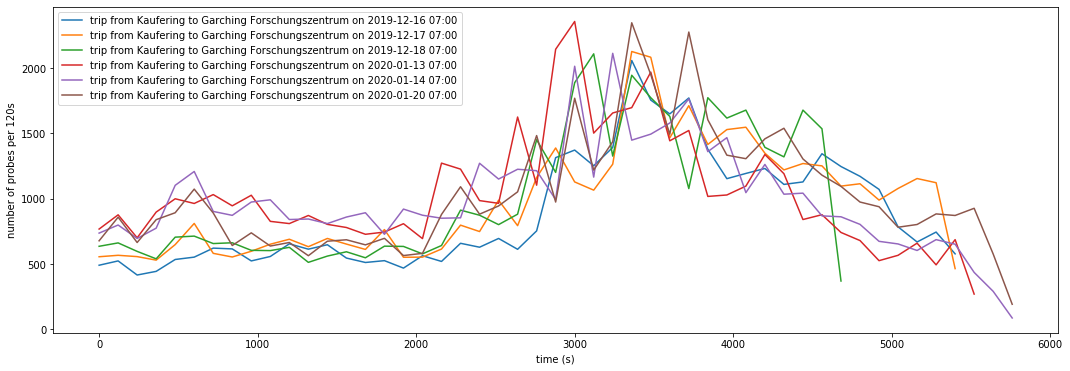

In [6]:
TIME_INTERVAL = 120

plots = []

for commute in commutes:
    timestamps = commute_time_series[commute][:]['timestamp']
    xs, ys = frequency_count(timestamps, TIME_INTERVAL)
    plots.append((xs, ys, make_legend(commute)))

plot_line_chart(plots, x_label='time (s)', y_label='number of probes per {}s'.format(TIME_INTERVAL))

# Observations
- The trip on 12/18/2019 (green line) ends early because of the battery running out.
- The change of number of packets per 100s across time is consistent in relative terms.
- The number of packets per 100s starts at about 500 in Kaufering, grows until Central Station until 2000 packets per 100s, 
  peaks multiple times around the city center, and decreases until the destination Garching Forschungszentrum.

In [7]:
from collections import defaultdict


def compute_inter_contact_times(probes):
    min_max_timestamps = defaultdict(tuple)  # mac -> min, max timestamp
    for probe in probes:
        current_min_max = min_max_timestamps[probe['mac']]
        min_timestamp = min([*current_min_max, probe['timestamp']])
        max_timestamp = max([*current_min_max, probe['timestamp']])
        min_max_timestamps[probe['mac']] = min_timestamp, max_timestamp
    return sorted(max_timestamp - min_timestamp for min_timestamp, max_timestamp in min_max_timestamps.values())

In [8]:
def compute_cdf(values):
    total = len(values)
    accumulator = 0
    ys, xs = [], []
    current_value = None
    for value in values:
        if current_value != value and current_value is not None:
            ys.append(accumulator)
            xs.append(current_value)
        current_value = value
        accumulator += 1 / total
    return xs, ys
    

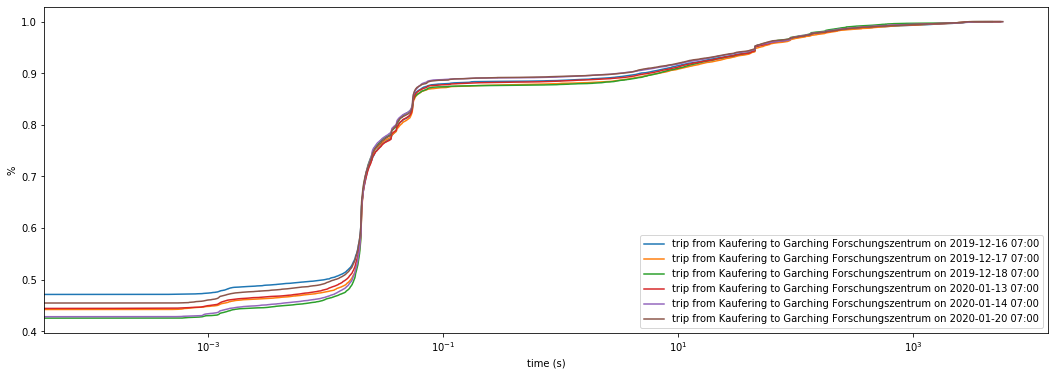

In [9]:
plots = []

for commute in commutes:
    inter_contact_times = compute_inter_contact_times(commute_time_series[commute])
    xs, ys = compute_cdf(inter_contact_times)
    plots.append((xs, ys, make_legend(commute)))

plot_line_chart(plots, x_label='time (s)', y_label='%', x_scale='log')

# Observations
- Almost 90% of MAC addresses are seen for less than 0.1 seconds.
 - Probably due to MAC address randomization
- The phone carried by the conductor of the measurement does not perform MAC address randomization. 

In [10]:
!wget http://standards-oui.ieee.org/oui/oui.csv

Will not apply HSTS. The HSTS database must be a regular and non-world-writable file.
ERROR: could not open HSTS store at '/home/lgfrbcsgo/.wget-hsts'. HSTS will be disabled.
--2020-02-08 17:09:52--  http://standards-oui.ieee.org/oui/oui.csv
Resolving standards-oui.ieee.org (standards-oui.ieee.org)... 140.98.223.27
Connecting to standards-oui.ieee.org (standards-oui.ieee.org)|140.98.223.27|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2480835 (2.4M) [application/octet-stream]
Saving to: ‘oui.csv.1’

oui.csv.1           100%[===================>]   2.37M   591KB/s    in 4.5s    

2020-02-08 17:09:57 (543 KB/s) - ‘oui.csv.1’ saved [2480835/2480835]



In [19]:
import csv
from collections import Counter
from tabulate import tabulate

with open('oui.csv', 'r') as file:
    reader = csv.reader(file)
    header = next(reader)
    vendors = {bytes.fromhex(row[1]): row[2] for row in reader}
    
for commute in commutes:
    macs = commute_time_series[commute][:]['mac']
    counter = Counter(vendors.get(mac[:3], '<randomized>') for mac in macs)
    print(make_legend(commute))
    print(tabulate(counter.most_common(10), headers=['vendor', 'count']))
    print('\n\n')
    

trip from Kaufering to Garching Forschungszentrum on 2019-12-16 07:00
vendor                                     count
---------------------------------------  -------
<randomized>                               28448
Raspberry Pi Foundation                     2238
Amazon Technologies Inc.                    1722
Samsung Electronics Co.,Ltd                 1581
HUAWEI TECHNOLOGIES CO.,LTD                 1129
OnePlus Tech (Shenzhen) Ltd                 1079
Sony Mobile Communications Inc               970
SAMSUNG ELECTRO-MECHANICS(THAILAND)          728
Apple, Inc.                                  672
Motorola Mobility LLC, a Lenovo Company      566



trip from Kaufering to Garching Forschungszentrum on 2019-12-17 07:00
vendor                                     count
---------------------------------------  -------
<randomized>                               31653
Raspberry Pi Foundation                     2326
Samsung Electronics Co.,Ltd                 1872
SAMSUNG ELECTRO-MECHANIC

# Observations
- The majority of MAC addresses is randomized.
- The Raspberry Pi is sending probe requests as well.
- The conductor of the measurements owns a OnePlus phone.
